In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-03')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[epoch:last, country].values
        D0 = death.loc[epoch:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [30]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e016c2803a6aaef99e20fd9e9c81e7a9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_480ac5eb816fc9bbcdd0b556dd97733b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b305bf3606a6c594794b11744bb1397a NOW.


In [32]:
## Model Validation ##

In [41]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      104.6    1.04  22.72  64.85   88.3  103.4 118.71 152.98    474    1.0
b_beta       5.0e-3  1.9e-4 1.9e-3 2.0e-3 3.6e-3 4.8e-3 6.2e-3 9.0e-3     94   1.08
b[1]           0.03  1.8e-3   0.03 4.1e-4 5.1e-3   0.02   0.05   0.09    211   1.02
b[2]           0.06  9.9e-4   0.02   0.02   0.04   0.05   0.07    0.1    464   1.01
b[3]           0.06  9.0e-4   0.02   0.02   0.04   0.06   0.07    0.1    464    1.0
b[4]           0.06  8.7e-4   0.02   0.03   0.05   0.06   0.07    0.1    453    1.0
b[5]           0.06  8.1e-4   0.02   0.03   0.05   0.06   0.07    0.1    465   1.01
b[6]           0.06  7.7e-4   0.02   0.03   0.05   0.06   0.08    0.1    489    1.0
b[7]           0.07  7.7e-4   0.02   0.04   0.06   0.07

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      48.37    2.72  32.46  16.83  26.64  37.61  59.93 136.22    142   1.03
b_beta       4.2e-3  2.2e-4 1.8e-3 1.1e-3 2.9e-3 4.0e-3 5.3e-3 8.4e-3     72   1.04
b[1]           0.03  3.2e-3   0.03 4.4e-4 5.0e-3   0.02   0.05    0.1    100   1.01
b[2]           0.05  2.4e-3   0.03 9.5e-3   0.03   0.05   0.07   0.11    141   1.03
b[3]           0.06  2.1e-3   0.03   0.01   0.04   0.05   0.07   0.11    153   1.03
b[4]           0.06  2.1e-3   0.03   0.02   0.04   0.06   0.07   0.11    151   1.02
b[5]           0.06  1.9e-3   0.02   0.02   0.04   0.06   0.08   0.11    160   1.02
b[6]           0.06  1.9e-3   0.02   0.02   0.04   0.06   0.08   0.11    164   1.02
b[7]           0.06  1.7e-3   0.02   0.02   0.05   0.06

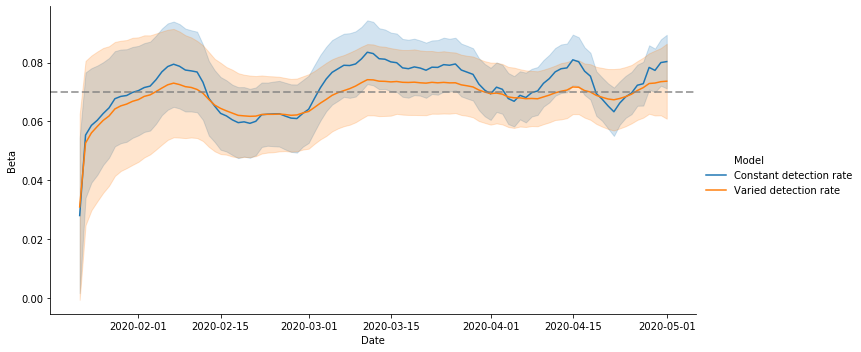

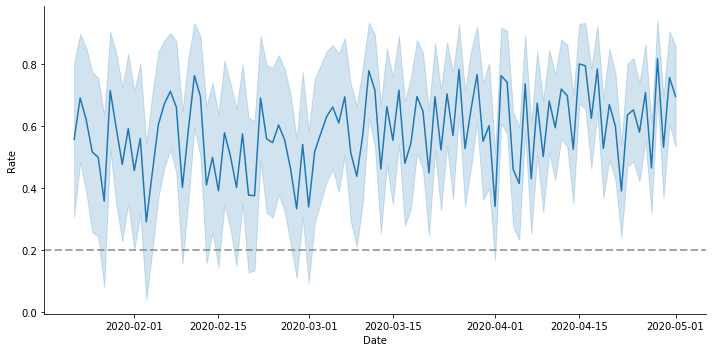

In [42]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [43]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      99.68    0.25   9.83   81.5  92.76  99.55 106.46 119.09   1520    1.0
b_beta       4.0e-3  1.2e-4 1.5e-3 1.6e-3 3.0e-3 3.8e-3 4.8e-3 7.4e-3    147   1.04
b[1]           0.06  3.5e-4   0.01   0.03   0.05   0.06   0.07   0.09   1464    1.0
b[2]           0.06  3.4e-4   0.01   0.04   0.05   0.06   0.07   0.09   1299    1.0
b[3]           0.06  3.2e-4   0.01   0.04   0.05   0.06   0.07   0.09   1239    1.0
b[4]           0.06  2.9e-4   0.01   0.04   0.06   0.06   0.07   0.09   1369    1.0
b[5]           0.06  3.0e-4   0.01   0.04   0.05   0.06   0.07   0.08   1184   1.01
b[6]           0.06  3.3e-4   0.01   0.04   0.05   0.06   0.07   0.08    963   1.01
b[7]           0.06  3.6e-4   0.01   0.04   0.05   0.06

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     137.85    1.53  37.35  92.44 112.03 128.34 153.46  236.3    597   1.01
b_beta       3.7e-3  1.2e-4 1.4e-3 1.6e-3 2.6e-3 3.5e-3 4.6e-3 6.9e-3    148   1.03
b[1]           0.07  5.3e-4   0.02   0.04   0.06   0.07   0.08   0.11    958    1.0
b[2]           0.07  5.4e-4   0.02   0.04   0.06   0.07   0.08   0.11    876    1.0
b[3]           0.07  5.4e-4   0.02   0.05   0.06   0.07   0.08   0.11    795    1.0
b[4]           0.08  5.3e-4   0.02   0.05   0.07   0.08   0.08   0.11    795    1.0
b[5]           0.07  5.3e-4   0.01   0.05   0.06   0.07   0.08    0.1    768    1.0
b[6]           0.07  5.2e-4   0.01   0.05   0.06   0.07   0.08    0.1    768    1.0
b[7]           0.07  5.1e-4   0.01   0.05   0.06   0.07

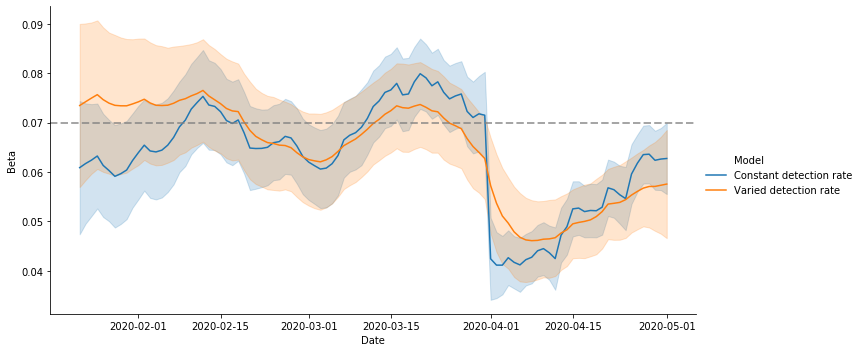

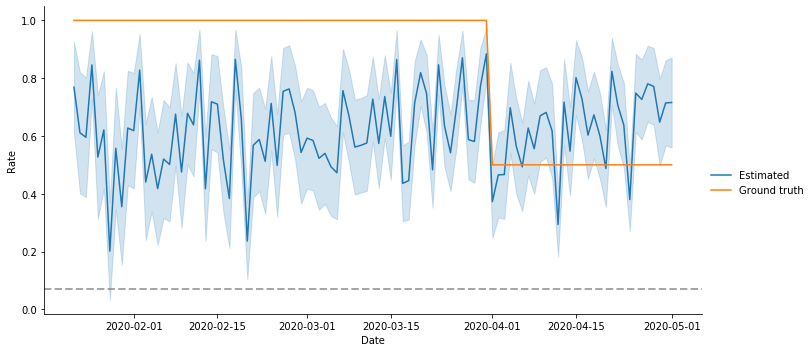

In [44]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', line=0.07, value_name='Rate', label_name='')

In [45]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        q.append(q0 + 0.05*np.random.randn(1)[0])
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        b.append(b[-1] - b1)
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      78.22    0.27  11.79  57.01  69.71  77.65   85.9 103.03   1881    1.0
b_beta         0.01  3.0e-5 1.4e-3 7.5e-3 9.0e-3 9.9e-3   0.01   0.01   2163    1.0
b[1]           0.17  7.8e-4   0.03   0.11   0.15   0.17   0.19   0.24   1627    1.0
b[2]           0.17  6.9e-4   0.03   0.12   0.15   0.17   0.19   0.23   1638    1.0
b[3]           0.17  6.5e-4   0.03   0.13   0.15   0.17   0.19   0.23   1550    1.0
b[4]           0.17  6.0e-4   0.02   0.13   0.16   0.17   0.19   0.22   1585    1.0
b[5]           0.17  5.6e-4   0.02   0.13   0.16   0.17   0.19   0.22   1596    1.0
b[6]           0.17  4.9e-4   0.02   0.14   0.16   0.17   0.19   0.22   1758    1.0
b[7]           0.17  4.8e-4   0.02   0.14   0.16   0.17

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      72.05    0.83  24.87  38.95  54.14  67.06  84.82 132.36    906    1.0
b_beta       3.7e-3  7.9e-5 1.3e-3 1.9e-3 2.8e-3 3.5e-3 4.4e-3 6.8e-3    264   1.02
b[1]           0.16  7.2e-4   0.03   0.11   0.14   0.16   0.17   0.21   1224    1.0
b[2]           0.16  7.3e-4   0.02   0.11   0.14   0.16   0.17   0.21   1150    1.0
b[3]           0.16  7.2e-4   0.02   0.11   0.14   0.16   0.17   0.21   1116    1.0
b[4]           0.16  7.2e-4   0.02   0.11   0.14   0.16   0.17   0.21   1021    1.0
b[5]           0.16  7.1e-4   0.02   0.12   0.14   0.16   0.17    0.2    977    1.0
b[6]           0.16  7.1e-4   0.02   0.12   0.14   0.16   0.17    0.2    924    1.0
b[7]           0.16  6.9e-4   0.02   0.12   0.14   0.16

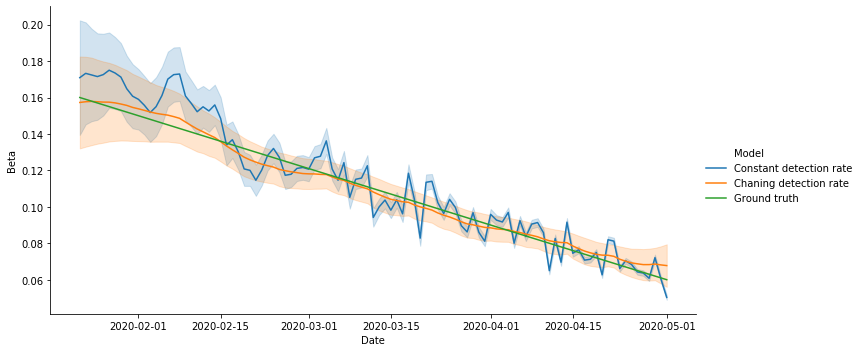

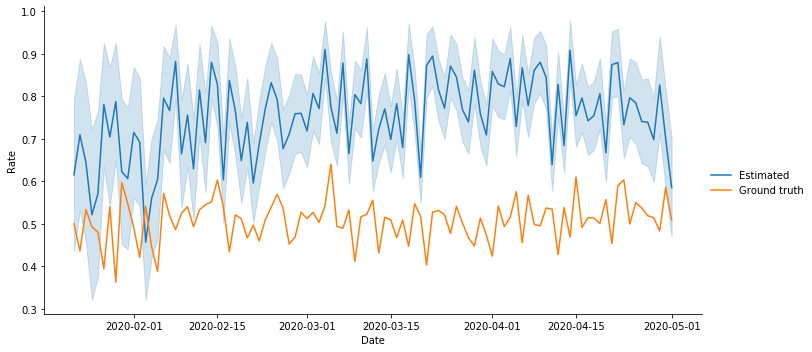

In [46]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

In [47]:
#### Satulate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.30, 0.2, 100, 0.04, 0.001, 12000_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.39    1.29   1.82   0.15   0.18   0.45    2.8   4.52      2 586.76
b_beta         0.97    0.36   0.51   0.25   0.45   1.04   1.47   1.53      2   58.4
b[1]           4.72    0.69   0.99   3.43   3.75   4.79   5.38   6.34      2   7.49
b[2]           2.56    1.88   2.66   0.24   0.51   1.41   4.78   7.11      2  65.54
b[3]           2.25    1.57   2.23   0.27   0.27   1.28    4.5    5.7      2  36.33
b[4]            1.7    0.59   0.84   0.35   0.93   1.98    2.4   2.45      2  43.42
b[5]           1.05    0.36    0.5   0.47   0.62   0.94    1.5   1.84      2  58.35
b[6]           0.54    0.18   0.25   0.15   0.32    0.6   0.76   0.84      2  79.14
b[7]           1.56    0.83   1.17   0.18   0.66   1.31

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       22.3    1.02    7.0  11.76  17.24  21.06  26.26  39.35     47    1.1
b_beta       5.1e-3  2.8e-4 1.6e-3 2.5e-3 3.9e-3 5.0e-3 6.1e-3 8.9e-3     33   1.11
b[1]            0.3  3.1e-3   0.03   0.24   0.29    0.3   0.32   0.37     98   1.05
b[2]            0.3  3.0e-3   0.03   0.25   0.29    0.3   0.32   0.36     90   1.05
b[3]            0.3  2.9e-3   0.03   0.25   0.29    0.3   0.32   0.36     87   1.05
b[4]            0.3  2.9e-3   0.03   0.25   0.29    0.3   0.32   0.36     82   1.05
b[5]            0.3  2.8e-3   0.02   0.25   0.29    0.3   0.32   0.35     78   1.06
b[6]            0.3  2.8e-3   0.02   0.26   0.29    0.3   0.32   0.35     71   1.07
b[7]            0.3  2.7e-3   0.02   0.26   0.29    0.3

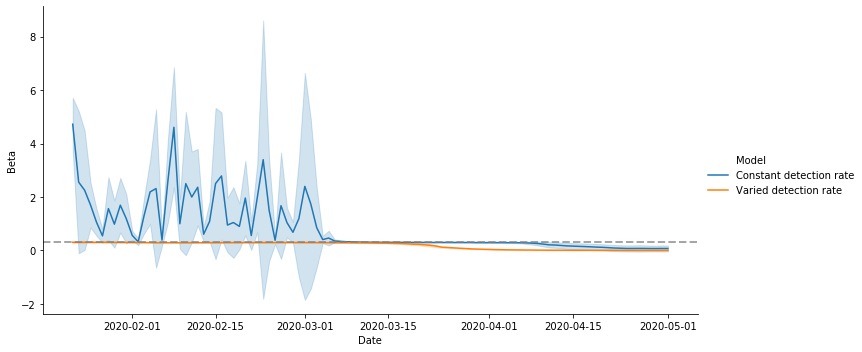

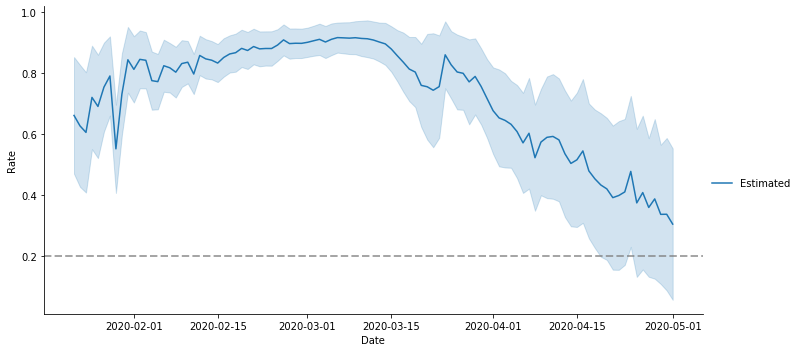

In [49]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.30, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', value_name='Rate', label_name='')

In [50]:
## Analysis ##
iteration = 2000

In [51]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}))

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      11.79    0.05   3.11   6.33   9.56  11.54  13.72  18.45   4627    1.0
b              0.09  1.4e-5 8.6e-4   0.09   0.09   0.09   0.09   0.09   3857    1.0
q               1.0  7.0e-6 5.3e-4    1.0    1.0    1.0    1.0    1.0   5672    1.0
NI[1]          1.21    0.01   0.77   0.08   0.63   1.12   1.67   2.94   4196    1.0
NI[2]          1.29    0.01   0.81    0.1   0.67   1.18    1.8   3.08   4120    1.0
NI[3]          1.38    0.01   0.83   0.11   0.74   1.28   1.92   3.25   4044    1.0
NI[4]          2.37    0.01   0.88   0.82   1.75   2.31   2.94   4.31   4431    1.0
NI[5]          1.55    0.02   0.92    0.1   0.85   1.46   2.16   3.61   3166    1.0
NI[6]          2.94    0.01   0.94   1.22   2.27   2.89

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.59    0.01   0.82   0.42   1.01   1.44   2.03   3.51   3011    1.0
b_beta         0.06  1.3e-4 7.5e-3   0.05   0.06   0.06   0.07   0.08   3453    1.0
b[1]           0.09  1.7e-3   0.08 4.0e-3   0.04   0.07   0.13    0.3   2099    1.0
b[2]           0.14  2.1e-3   0.09   0.01   0.08   0.13    0.2   0.36   2037    1.0
b[3]           0.19  2.2e-3    0.1   0.03   0.12   0.18   0.25   0.42   2036    1.0
b[4]           0.24  2.2e-3    0.1   0.08   0.16   0.23   0.29   0.46   2070    1.0
b[5]           0.25  2.5e-3    0.1   0.06   0.17   0.24   0.31   0.48   1792    1.0
b[6]           0.27  2.2e-3    0.1   0.11    0.2   0.27   0.33   0.49   2029    1.0
b[7]           0.27  2.3e-3    0.1   0.09    0.2   0.26

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.46    0.21   5.79   1.11   2.52   3.94   6.27  19.03    781    1.0
b_beta         0.02  2.7e-4 4.1e-3 8.8e-3   0.01   0.01   0.02   0.02    233   1.03
b[1]           0.07  2.5e-3   0.07 1.6e-3   0.02   0.04   0.11   0.23    714    1.0
b[2]            0.1  2.5e-3   0.07 8.7e-3   0.05   0.09   0.15   0.25    777    1.0
b[3]           0.13  2.2e-3   0.07   0.02   0.08   0.12   0.17   0.27    947    1.0
b[4]           0.15  2.0e-3   0.06   0.04   0.11   0.15   0.19   0.28    944    1.0
b[5]           0.16  2.0e-3   0.06   0.06   0.12   0.16    0.2   0.28    820   1.01
b[6]           0.17  2.1e-3   0.05   0.07   0.13   0.16    0.2   0.29    665   1.01
b[7]           0.17  2.0e-3   0.05   0.08   0.14   0.17

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo  3768.68   639.45
p_loo    930.15        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       32   31.4%
 (0.5, 0.7]   (ok)         22   21.6%
   (0.7, 1]   (bad)         8    7.8%
   (1, Inf)   (very bad)   40   39.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   717.88    28.02
p_loo     80.04        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8    7.8%
 (0.5, 0.7]   (ok)         28   27.5%
   (0.7, 1]   (bad)        48   47.1%
   (1, Inf)   (very bad)   18   17.6%

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   701.89    27.95
p_loo     74.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    6.9%
 (0.5, 0.7]   (ok)         20   19.6%
   (0.7, 1]   (bad)        69   67.6%
   (1, Inf)   (very bad)    6    5.9%

         rank     waic   p_waic   d_waic     weight       se      dse warning  \
Varied_q    0  655.764  51.2816        0   0.979477   891.95     

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


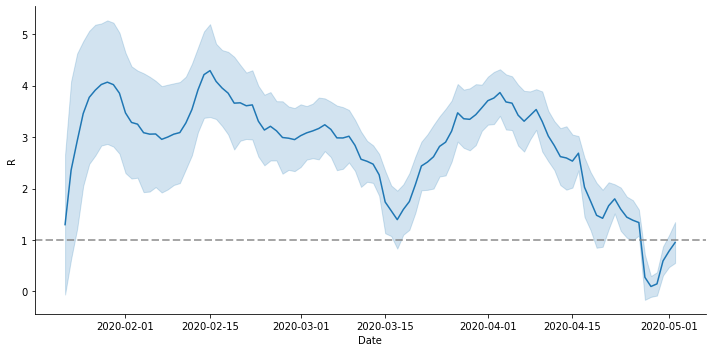

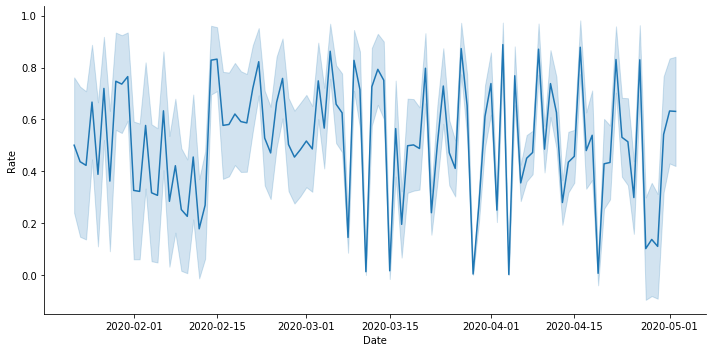

In [52]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_J = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [72]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6467.9    0.95   81.7 6313.1 6410.4 6469.3 6522.3 6631.2   7357    1.0
b              0.06  3.6e-6 2.8e-4   0.06   0.06   0.06   0.06   0.06   5874    1.0
q               1.0  5.4e-7 3.9e-5    1.0    1.0    1.0    1.0    1.0   5366    1.0
NI[1]        451.83    0.19  17.41 417.18 440.17 451.51 463.63 485.43   8241    1.0
NI[2]        575.97    0.17  16.79 543.04 564.18 575.98 587.62 608.21   9289    1.0
NI[3]        689.65    0.18  16.35 657.25 678.84 689.69 700.49 721.52   8590    1.0
NI[4]        783.68    0.19  17.28 750.15 771.84 783.16 795.25  818.2   8328    1.0
NI[5]        856.99    0.17   17.4 822.73 845.07 857.13 868.86 891.22  10748    1.0
NI[6]        1346.6    0.19  17.25 1312.9 1335.0 1346.8

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     555.92    0.37  22.99 511.48 540.17 555.85 571.36 600.62   3881    1.0
b_beta       7.7e-3  2.0e-5 1.4e-3 5.4e-3 6.7e-3 7.6e-3 8.6e-3   0.01   4854    1.0
b[1]           0.17  3.8e-4   0.03   0.12   0.15   0.17   0.19   0.23   5037    1.0
b[2]           0.48  4.0e-4   0.02   0.44   0.46   0.48   0.49   0.52   2730    1.0
b[3]           0.48  3.7e-4   0.02   0.45   0.47   0.48   0.49   0.52   2552    1.0
b[4]           0.48  3.6e-4   0.02   0.44   0.46   0.48   0.49   0.51   2412    1.0
b[5]           0.46  3.5e-4   0.02   0.42   0.45   0.46   0.48    0.5   3161    1.0
b[6]           0.98  4.5e-4   0.03   0.92   0.96   0.98    1.0   1.05   5209    1.0
b[7]           0.11  9.1e-5 6.7e-3    0.1   0.11   0.11

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9630.1   61.33 1407.6 7135.4 8692.8 9549.6  1.0e4  1.3e4    527    1.0
b_beta       1.3e-3  1.4e-5 3.1e-4 7.6e-4 1.0e-3 1.2e-3 1.4e-3 1.9e-3    482    1.0
b[1]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    295   1.01
b[2]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    291   1.01
b[3]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    283   1.01
b[4]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    281   1.01
b[5]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    274   1.01
b[6]           0.16  6.4e-4   0.01   0.15   0.16   0.16   0.17   0.19    266   1.01
b[7]           0.16  6.5e-4   0.01   0.15   0.16   0.16

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo 39621.39  17863.80
p_loo   3495.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          2    2.0%
   (0.7, 1]   (bad)         5    4.9%
   (1, Inf)   (very bad)   94   92.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   941.75    22.83
p_loo     88.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          8    7.8%
   (0.7, 1]   (bad)        75   73.5%
   (1, Inf)   (very bad)   19   18.6%

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   918.63    21.12
p_loo     78.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          5    4.9%
   (0.7, 1]   (bad)        84   82.4%
   (1, Inf)   (very bad)   12   11.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,860.862,49.7787,0,0.996051,28299.1,0,True,deviance
Const_q,1,875.468,54.9829,14.6064,0.00394873,21.6078,4.98812,True,deviance
Const,2,55975.4,11672.1,55114.6,0,20.755,26623.3,True,deviance


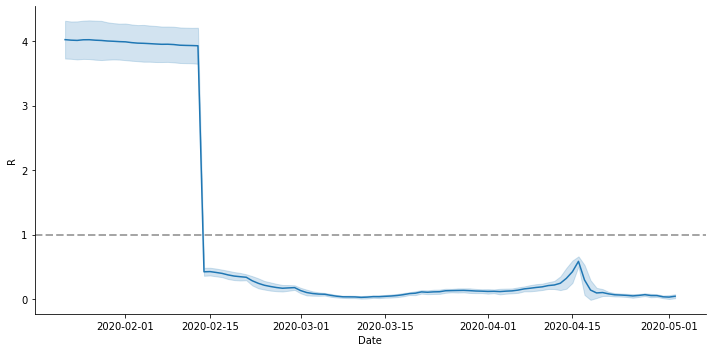

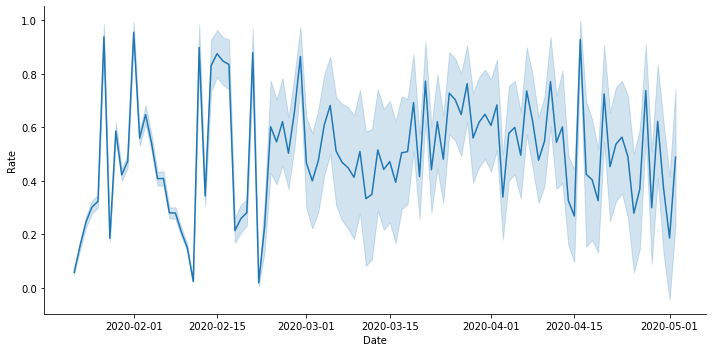

In [74]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_C = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [55]:
### US ###
P = 327_200_000
country='US'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      153.5    0.15  13.35 127.87 144.02 153.33 162.23 180.26   7646    1.0
b               0.1  1.5e-6 1.0e-4   0.09    0.1    0.1    0.1    0.1   4495    1.0
q               1.0  2.0e-7 1.8e-5    1.0    1.0    1.0    1.0    1.0   7350    1.0
NI[1]         15.03    0.05   3.65   8.01  12.51  15.04  17.44  22.34   5404    1.0
NI[2]         17.29    0.04   3.73   9.97  14.82  17.24  19.77  24.67   7903    1.0
NI[3]         18.09    0.05   3.87  10.67  15.49   18.1  20.61  25.69   6955    1.0
NI[4]         22.01    0.04   3.82   14.7  19.34  21.98  24.58  29.81   8582    1.0
NI[5]         21.66    0.05   4.16  13.47  18.82  21.62  24.53  29.71   6030    1.0
NI[6]         23.76    0.04   4.28  15.52  20.77  23.71

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.41    0.04   0.78   0.32   0.86   1.27   1.78   3.41    431   1.01
b_beta         0.03  3.2e-4 5.5e-3   0.02   0.03   0.03   0.04   0.05    292   1.02
b[1]           0.06  2.8e-3   0.05 4.1e-3   0.02   0.05   0.08    0.2    370    1.0
b[2]            0.1  2.6e-3   0.06   0.02   0.06   0.09   0.13   0.24    470    1.0
b[3]           0.12  2.9e-3   0.06   0.03   0.08   0.11   0.16   0.25    393   1.01
b[4]           0.14  3.2e-3   0.06   0.04    0.1   0.13   0.17   0.27    349   1.01
b[5]           0.13  3.2e-3   0.06   0.04   0.09   0.13   0.17   0.27    338   1.01
b[6]           0.13  3.9e-3   0.06   0.04   0.09   0.12   0.16   0.26    222   1.02
b[7]           0.13  4.4e-3   0.06   0.02   0.09   0.12

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.91    0.05   2.35   0.63   1.52   2.32   3.59   8.73   2272    1.0
b_beta         0.02  2.4e-4 4.2e-3   0.01   0.01   0.02   0.02   0.03    303   1.01
b[1]           0.06  1.4e-3   0.05 2.0e-3   0.02   0.04   0.08   0.19   1331    1.0
b[2]           0.09  1.5e-3   0.05   0.02   0.05   0.08   0.12   0.21   1221   1.01
b[3]            0.1  1.5e-3   0.05   0.03   0.07    0.1   0.14   0.22   1075   1.01
b[4]           0.12  1.5e-3   0.05   0.04   0.08   0.11   0.15   0.23   1122   1.01
b[5]           0.12  1.5e-3   0.05   0.04   0.08   0.11   0.15   0.23   1031   1.01
b[6]           0.12  1.5e-3   0.05   0.04   0.09   0.12   0.15   0.23   1044   1.01
b[7]           0.12  1.5e-3   0.05   0.04   0.09   0.12

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo 106902.74  11014.50
p_loo   9992.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)   99   97.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   996.65    61.15
p_loo     98.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       23   22.5%
 (0.5, 0.7]   (ok)         12   11.8%
   (0.7, 1]   (bad)        55   53.9%
   (1, Inf)   (very bad)   12   11.8%

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   947.90    57.97
p_loo     79.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       15   14.7%
 (0.5, 0.7]   (ok)         12   11.8%
   (0.7, 1]   (bad)        63   61.8%
   (1, Inf)   (very bad)   12   11.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,899.464,55.1883,0,0.999913,17505,0,True,deviance
Const_q,1,932.496,66.686,33.032,8.65674e-05,55.5719,11.0056,True,deviance
Const,2,164014,38547.5,163114,0,56.0275,18218.5,True,deviance


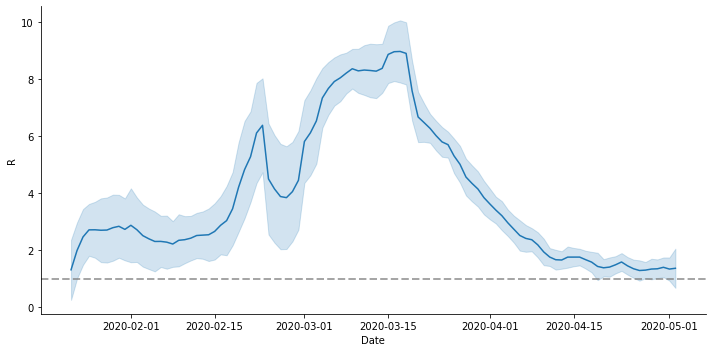

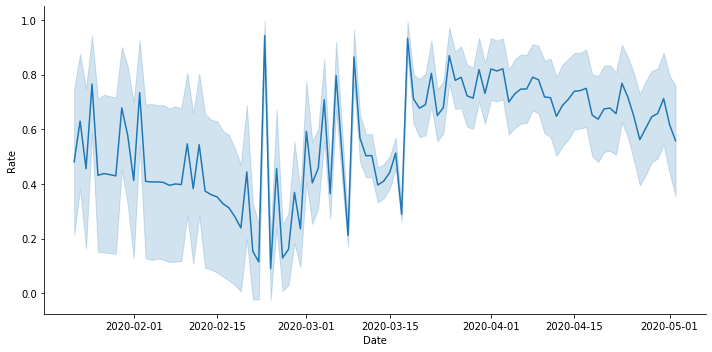

In [56]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_US = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [59]:
# ### Italy ###
# P = 60_360_000
# country='Italy'
# start=pd.to_datetime('2020-01-22')
# infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
# infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
# infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
# loo = az.loo(infer_const, pointwise=True)
# print(loo)
# loo = az.loo(infer_const_q, pointwise=True)
# print(loo)
# loo = az.loo(infer, pointwise=True)
# print(loo)
# az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

RuntimeError: Initialization failed.

In [ ]:
# beta = extract_var(var_name='b', data=infer)
# q = extract_var(var_name='q', data=infer)
# C = extract_var(var_name='C', data=infer)
# C = C[:-1]
# d = extract_var(var_name='d', data=infer)
# R_I = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
#                  index=beta.index)

# draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
# draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [62]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      135.0    0.16  12.98  110.9  126.1 134.54 143.42 161.33   6193    1.0
b              0.06  9.5e-6 7.2e-4   0.06   0.06   0.06   0.07   0.07   5744    1.0
q               1.0  5.0e-6 3.8e-4    1.0    1.0    1.0    1.0    1.0   5741    1.0
NI[1]          9.02    0.04   2.82   3.63   7.05   8.97  10.94  14.58   4682    1.0
NI[2]         10.47    0.04   2.73    5.3   8.61  10.42  12.24  15.98   5783    1.0
NI[3]         10.24    0.04   2.94   4.57   8.23  10.23  12.22  16.19   5502    1.0
NI[4]         11.69    0.04   2.88   6.15    9.7  11.68   13.6   17.5   5752    1.0
NI[5]         12.37    0.04   2.91   6.79  10.38  12.33  14.38  18.16   5285    1.0
NI[6]         12.41    0.04   3.02    6.6  10.41  12.37

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.42    0.03   1.35   0.66   1.47   2.13   3.05   5.82   1693    1.0
b_beta       9.9e-3  5.7e-5 1.9e-3 6.7e-3 8.6e-3 9.8e-3   0.01   0.01   1045    1.0
b[1]           0.06  2.3e-3   0.06 1.3e-3   0.01   0.04    0.1    0.2    605    1.0
b[2]           0.09  2.2e-3   0.05   0.01   0.05   0.09   0.13   0.21    642    1.0
b[3]            0.1  2.1e-3   0.05   0.02   0.07    0.1   0.14   0.21    614    1.0
b[4]           0.12  1.9e-3   0.05   0.04   0.08   0.11   0.14   0.21    587    1.0
b[5]           0.12  1.7e-3   0.04   0.04   0.09   0.12   0.15   0.21    615    1.0
b[6]           0.13  1.7e-3   0.04   0.05    0.1   0.12   0.15   0.21    629    1.0
b[7]           0.13  1.5e-3   0.04   0.06    0.1   0.13

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      287.6  352.33 524.37   0.38   0.99   1.65 246.07 1589.7      2   3.43
b_beta       2.8e-3  4.6e-4 1.2e-3 1.1e-3 2.0e-3 2.6e-3 3.5e-3 5.7e-3      7   1.27
b[1]           0.12    0.07   0.13 1.2e-4 1.7e-3 7.6e-3   0.26    0.3      3   1.91
b[2]           0.19    0.08   0.11 9.3e-4   0.01   0.25   0.27   0.31      2   3.61
b[3]           0.19    0.08   0.11 5.8e-4   0.02   0.25   0.27   0.31      2   4.07
b[4]           0.19    0.08   0.11 1.1e-3   0.03   0.25   0.27   0.31      2   4.39
b[5]           0.19    0.08   0.11 1.2e-3   0.03   0.25   0.27   0.31      2   4.44
b[6]           0.19    0.08   0.11 8.0e-4   0.02   0.25   0.27   0.31      2   4.56
b[7]            0.2    0.08   0.11 1.0e-3   0.04   0.25

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo  6816.35  1196.00
p_loo   1263.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.9%
 (0.5, 0.7]   (ok)         11   10.8%
   (0.7, 1]   (bad)        19   18.6%
   (1, Inf)   (very bad)   67   65.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   736.48    37.58
p_loo     82.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       17   16.7%
 (0.5, 0.7]   (ok)         27   26.5%
   (0.7, 1]   (bad)        48   47.1%
   (1, Inf)   (very bad)   10    9.8%

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   707.42    26.66
p_loo     76.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    2.0%
 (0.5, 0.7]   (ok)         12   11.8%
   (0.7, 1]   (bad)        79   77.5%
   (1, Inf)   (very bad)    9    8.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densiti

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,653.898,49.8916,0,0.998449,1503,0,True,deviance
Const_q,1,696.203,62.4224,42.3044,0.00155135,36.1854,22.8393,True,deviance
Const,2,7692.5,1701.42,7038.6,0,25.7693,1490.68,True,deviance


In [70]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

KeyError: 'q'

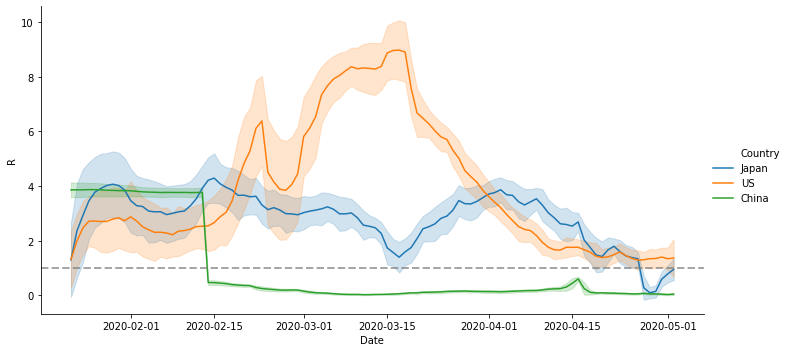

In [61]:
draw({'Japan':R_J, 'US':R_US, 'China':R_C}, line=1, name='R_multi', value_name='R', label_name='Country')